In this exercise, we try to reproduce the findings of the article “Quantifying the Advantage of Looking Forward” http://www.nature.com/articles/srep00350.

According to the study, the GDP per capita of countries is positively correlated to how much their population searches in Google for the next year, relative to how much they search for the previous year.

This ratio is called the Future Orientation Index (FOI). So for example for the year 2017 the FOI can be calculated as: FOI = number of searches for the term “2018” / number of searches for the term “2016”.

In [1]:
%%capture

import sys

# to install with pip
# !{sys.executable} -m pip install wbgapi
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install scipy

# to install with conda
# !conda install --yes --prefix {sys.prefix} wbgapi
# !conda install --yes --prefix {sys.prefix} pandas
# !conda install --yes --prefix {sys.prefix} matplotlib
# !conda install --yes --prefix {sys.prefix} scipy

import wbgapi as wb
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

## World Bank Data

### Download WDI data

From the WDI we need three indicators:

    Gross Domestic Product (GDP) per capita corrected by the Purchase Power Parity (PPP in current or 2005 international $, “NY.GDP.PCAP.PP.KD”)

    The amount of Internet users (per 100 people, “IT.NET.USER.ZS”)

    The total population (described as as “Population, Total”, “SP.POP.TOTL”)

In the following code chunk, download all data (including extras) for all countries in year 2014.

Hint: To remove aggregates (economic regions defined by the World Bank) and include only countries, use 'skipAggs=True'.

In [2]:
# get a dataframe from the year 2014 of our variables above

# only if you are stuck:
# if the package doesn't work for you, to continue load the provided data with 
# WDIdf =  pd.read_csv("world_bank_data.csv")

WDIdf = wb.data.DataFrame(['NY.GDP.PCAP.PP.KD', 'SP.POP.TOTL', 'IT.NET.USER.ZS'],
             labels = True,time=2014, skipAggs=True)

# WDIdf.to_csv("world_bank_data.csv")

# WDIdf =  pd.read_csv("world_bank_data.csv")

WDIdf

,Country,IT.NET.USER.ZS,NY.GDP.PCAP.PP.KD,SP.POP.TOTL
economy,,,,
ZWE,Zimbabwe,16.36474,3703.897236,13586710.0
ZMB,Zambia,6.50000,3450.037600,15399793.0
YEM,"Yemen, Rep.",22.55000,NaN,25823488.0
PSE,West Bank and Gaza,53.67000,5967.073437,4173398.0
VIR,Virgin Islands (U.S.),50.07000,NaN,107882.0
...,...,...,...,...
AND,Andorra,86.10000,NaN,79213.0
ASM,American Samoa,NaN,NaN,55791.0
DZA,Algeria,29.50000,11512.690472,38923688.0


In [3]:
#only keep complete cases (drop any row that has NAs)
WDIdf.dropna(axis = 0, how = 'any', inplace = True)

WDIdf

,Country,IT.NET.USER.ZS,NY.GDP.PCAP.PP.KD,SP.POP.TOTL
economy,,,,
ZWE,Zimbabwe,16.36474,3703.897236,13586710.0
ZMB,Zambia,6.50000,3450.037600,15399793.0
PSE,West Bank and Gaza,53.67000,5967.073437,4173398.0
VNM,Vietnam,41.00000,7601.858491,91713850.0
VUT,Vanuatu,18.80000,2984.243485,263888.0
...,...,...,...,...
ATG,Antigua and Barbuda,67.78000,18104.683788,92562.0
AGO,Angola,21.40000,8240.347981,26941773.0
DZA,Algeria,29.50000,11512.690472,38923688.0


In [4]:
#filter for at least 5 Million internet users
WDIdff = WDIdf.loc[(WDIdf['SP.POP.TOTL']*WDIdf['IT.NET.USER.ZS'])/100>5000000]

WDIdff

,Country,IT.NET.USER.ZS,NY.GDP.PCAP.PP.KD,SP.POP.TOTL
economy,,,,
VNM,Vietnam,41.000000,7601.858491,91713850.0
UZB,Uzbekistan,35.500000,6075.192224,30757700.0
USA,United States,73.000000,57300.607155,318386329.0
GBR,United Kingdom,91.610000,44239.151060,64602298.0
ARE,United Arab Emirates,90.400000,62452.184508,9214182.0
...,...,...,...,...
AUT,Austria,80.995825,52932.900112,8546356.0
AUS,Australia,84.000000,47232.875387,23475686.0
ARG,Argentina,64.700000,23550.099060,42669500.0


## The Future Orientation Index in Google Trends

### Download data from Google Trends

You can download the data from Google Trends following these steps:

    Log out from your google account or set its language to English
    
    Go to trends.google.com and search for 2013
    
    Add 2015 as a search term
    
    Select custom time rage: full year: 2014
    
    Set the region to “Worldwide”. You can also try with this link: https://trends.google.com/trends/explore?date=2014-01-01%202014-12-31&q=2013,2015
    
    Go to the map at “Compared breakdown by region” and tick on “include low search volume regions”
    
    On the top right menu click the download button to get a geoMap.csv file

Load the .csv file, drop NAs and bring it in the right data format.

If you have problems getting the file from the web interface, we also included it in the github repository.

In [5]:
GoogleDF = pd.read_csv("geoMap.csv", skiprows=3, names=["Country", "G2013", "G2015"])

GoogleDF.dropna(axis = 0, how = 'any', inplace = True)

GoogleDF['G2013'] = GoogleDF['G2013'].str.replace('\%','',regex=True).astype(int)

GoogleDF['G2015'] = GoogleDF['G2015'].str.replace('\%','',regex=True).astype(int)

GoogleDF.head()

,Country,G2013,G2015
0,Western Sahara,31,69
1,Algeria,65,35
2,Moldova,87,13
3,Armenia,85,15
4,Pakistan,84,16


### Calculate the Future Orientation Index

In the following code chunk, make a new column in the Google Trends dataframe with the Future Orientation Index, which is the ratio between the search volume for 2015 and 2013 in 2014 for each country

In [6]:
GoogleDF['FOI'] = GoogleDF['G2015']/GoogleDF['G2013']
GoogleDF.head()

,Country,G2013,G2015,FOI
0,Western Sahara,31,69,2.225806
1,Algeria,65,35,0.538462
2,Moldova,87,13,0.149425
3,Armenia,85,15,0.176471
4,Pakistan,84,16,0.190476


### Merge with World Bank data

Merge the WDI and google trends data frames, using the name of the country.

In [7]:
allDF = WDIdff.merge(GoogleDF,on="Country")

allDF.head()

,Country,IT.NET.USER.ZS,NY.GDP.PCAP.PP.KD,SP.POP.TOTL,G2013,G2015,FOI
0,Vietnam,41.00,7601.858491,91713850.0,78,22,0.282051
1,Uzbekistan,35.50,6075.192224,30757700.0,71,29,0.408451
2,United States,73.00,57300.607155,318386329.0,58,42,0.724138
3,United Kingdom,91.61,44239.151060,64602298.0,54,46,0.851852
4,United Arab Emirates,90.40,62452.184508,9214182.0,67,33,0.492537


## Testing the correlation between GDP and FOI

### Visualize FOI vs GDP

Now that you have the FOI index and GPD per capita, PPP value for each country, you can make a scatter plot of FOI vs GDP.

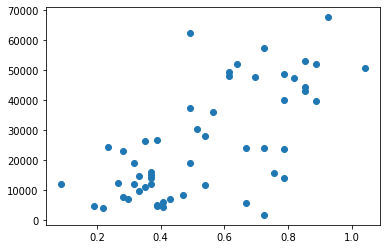

In [8]:
plt.scatter(allDF['FOI'], allDF['NY.GDP.PCAP.PP.KD'])
plt.show()

### Measure Pearson’s correlation

In the following chunk, calculate Pearson’s correlation coefficient between GDP and FOI

In [9]:
stats.pearsonr(allDF['FOI'], allDF['NY.GDP.PCAP.PP.KD'])

(0.6644049508463793, 4.3022606310730166e-08)

### Measure correlation after shuffling

What happens if we shuffle the data (e.g. shuffle the FOIs) and repeat the above analysis? Do you find any difference between the two plots and two Pearson’s correlation coefficients?

       Country  IT.NET.USER.ZS  NY.GDP.PCAP.PP.KD  SP.POP.TOTL  G2013  G2015  \
1   Uzbekistan            35.5        6075.192224   30757700.0     71     29   
53     Algeria            29.5       11512.690472   38923688.0     65     35   
36    Ethiopia             7.7        1656.634489   98094264.0     58     42   
21     Morocco            56.8        6911.803223   34192358.0     70     30   
51   Argentina            64.7       23550.099060   42669500.0     56     44   

         FOI  
1   0.408451  
53  0.538462  
36  0.724138  
21  0.428571  
51  0.785714  


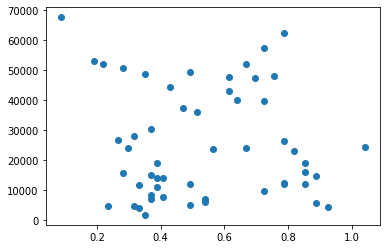

(-0.06969072923063314, 0.6165493974288071)

In [9]:
allDFshuff=allDF.sample(frac=1)

print(allDFshuff.head())

plt.scatter(allDFshuff['FOI'], allDF['NY.GDP.PCAP.PP.KD'])
plt.show()

stats.pearsonr(allDFshuff['FOI'], allDF['NY.GDP.PCAP.PP.KD'])

## If you want to do more

### Check robustness

    What result do you get if you use other years? What if you choose one of the earliest years in Google trends?
    
    How do results change if you use a different threshod instead of 5 Million Internet users?
    
### Test other hypotheses
    
    Is future orientation generating wealth? Or is wealth enabling to look more to the future?
    
    Is the FOI really measuring orientation to the future? Could it be something else?